# Comparison: MNIST vs CIFAR-10

Let's compare the performance of both models and datasets.

In [1]:
# MNIST CNN Training with PyTorch on Apple M4
# Optimized for Apple Silicon MPS backend

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
# Confusion matrix visualization
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from tqdm import tqdm
import time
import importlib

from ml_modules import data
importlib.reload(data)

from ml_modules import models
importlib.reload(models)

from ml_modules import visualize
importlib.reload(visualize)

from ml_modules import train
importlib.reload(train)

# Check for Apple Silicon MPS availability
print(f"PyTorch version: {torch.__version__}")
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"MPS built: {torch.backends.mps.is_built()}")

# Set device - prioritize MPS for Apple Silicon
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon MPS")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("Using CPU")

PyTorch version: 2.7.1
MPS available: True
MPS built: True
Using Apple Silicon MPS


In [2]:
# Initialize CIFAR-10 model
model_cifar = models.CIFAR10CNN().to(device)

# Count parameters
total_params_cifar = sum(p.numel() for p in model_cifar.parameters())
trainable_params_cifar = sum(p.numel() for p in model_cifar.parameters() if p.requires_grad)
print(f"CIFAR-10 Model - Total parameters: {total_params_cifar:,}")
print(f"CIFAR-10 Model - Trainable parameters: {trainable_params_cifar:,}")

# Loss function and optimizer for CIFAR-10
criterion_cifar = nn.CrossEntropyLoss()
optimizer_cifar = optim.AdamW(model_cifar.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler with cosine annealing for better CIFAR-10 performance
scheduler_cifar = optim.lr_scheduler.CosineAnnealingLR(optimizer_cifar, T_max=50, eta_min=1e-6)

CIFAR-10 Model - Total parameters: 7,320,394
CIFAR-10 Model - Trainable parameters: 7,320,394


In [3]:
train_loader_cifar, test_loader_cifar, cifar_data_info = data.get_cifar10_loaders()
cifar_data_info

{'name': 'CIFAR-10',
 'num_classes': 10,
 'input_shape': (3, 32, 32),
 'train_samples': 50000,
 'test_samples': 10000,
 'class_names': ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck']}

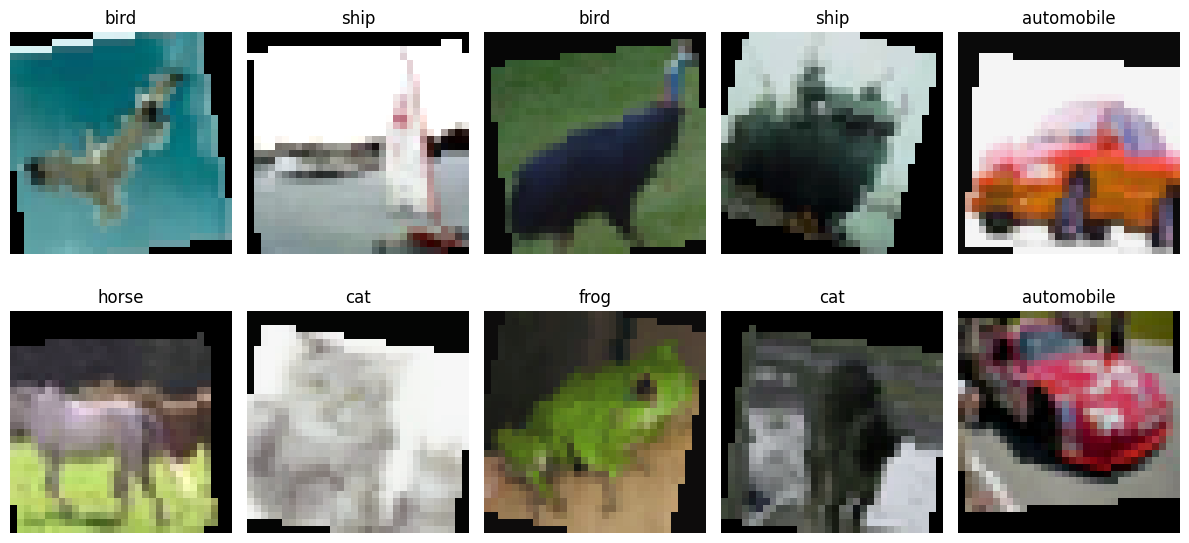

CIFAR-10 image shape: torch.Size([3, 32, 32])


In [4]:
images_cifar, labels_cifar = visualize.show_cifar_samples(loader_cifar=train_loader_cifar,cifar10_classes=cifar_data_info['class_names'])
print(f"CIFAR-10 image shape: {images_cifar[0].shape}")

In [5]:
# CIFAR-10 Training loop
num_epochs_cifar = 0 #25
train_losses_cifar = []
train_accuracies_cifar = []
test_losses_cifar = []
test_accuracies_cifar = []

print("Starting CIFAR-10 training...")
start_time_cifar = time.time()

best_accuracy_cifar = 0

for epoch in range(num_epochs_cifar):
    print(f'\nCIFAR-10 Epoch {epoch+1}/{num_epochs_cifar}')
    print('-' * 50)
    
    # Train
    train_loss_cifar, train_acc_cifar = train.train_epoch(model_cifar, train_loader_cifar, criterion_cifar, optimizer_cifar, device)
    
    # Test
    test_loss_cifar, test_acc_cifar = train.test_epoch(model_cifar, test_loader_cifar, criterion_cifar, device)
    
    # Update scheduler
    scheduler_cifar.step()
    
    # Store metrics
    train_losses_cifar.append(train_loss_cifar)
    train_accuracies_cifar.append(train_acc_cifar)
    test_losses_cifar.append(test_loss_cifar)
    test_accuracies_cifar.append(test_acc_cifar)
    
    # Save best model
    if test_acc_cifar > best_accuracy_cifar:
        best_accuracy_cifar = test_acc_cifar
        torch.save(model_cifar.state_dict(), 'best_cifar10_model.pth')
        print(f"New best CIFAR-10 model saved! Accuracy: {test_acc_cifar:.2f}%")
    
    print(f'Train Loss: {train_loss_cifar:.4f}, Train Acc: {train_acc_cifar:.2f}%')
    print(f'Test Loss: {test_loss_cifar:.4f}, Test Acc: {test_acc_cifar:.2f}%')
    print(f'Learning Rate: {scheduler_cifar.get_last_lr()[0]:.6f}')

total_time_cifar = time.time() - start_time_cifar
print(f'\nCIFAR-10 Training completed in {total_time_cifar:.2f} seconds')
print(f'Best CIFAR-10 test accuracy: {best_accuracy_cifar:.2f}%')

Starting CIFAR-10 training...

CIFAR-10 Training completed in 0.00 seconds
Best CIFAR-10 test accuracy: 0.00%


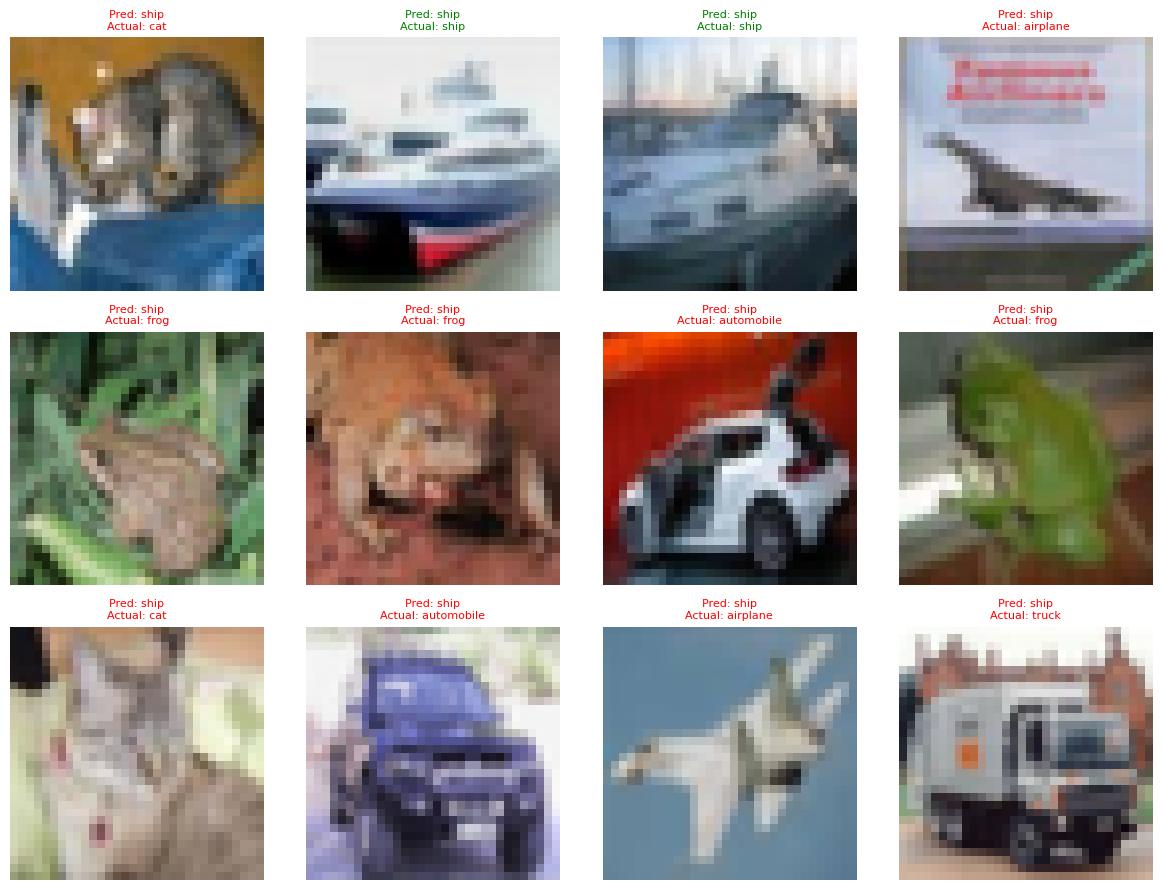


Final CIFAR-10 Model Performance:
Best Test Accuracy: 0.00%
Total Training Time: 0.00 seconds
Model Size: 7,320,394 parameters
Device Used: mps

CIFAR-10 training history saved to 'training_history_cifar10.pth'
Best CIFAR-10 model saved to 'best_cifar10_model.pth'


In [6]:
importlib.reload(visualize)
visualize.show_cifar_predictions(model_cifar, test_loader_cifar, device, cifar10_classes=cifar_data_info["class_names"])

# Final CIFAR-10 model summary
print(f"\nFinal CIFAR-10 Model Performance:")
print(f"Best Test Accuracy: {best_accuracy_cifar:.2f}%")
print(f"Total Training Time: {total_time_cifar:.2f} seconds")
print(f"Model Size: {total_params_cifar:,} parameters")
print(f"Device Used: {device}")

# Save CIFAR-10 training history
training_history_cifar = {
    'train_losses': train_losses_cifar,
    'train_accuracies': train_accuracies_cifar,
    'test_losses': test_losses_cifar,
    'test_accuracies': test_accuracies_cifar,
    'best_accuracy': best_accuracy_cifar,
    'total_time': total_time_cifar
}

torch.save(training_history_cifar, 'training_history_cifar10.pth')
print("\nCIFAR-10 training history saved to 'training_history_cifar10.pth'")
print("Best CIFAR-10 model saved to 'best_cifar10_model.pth'")

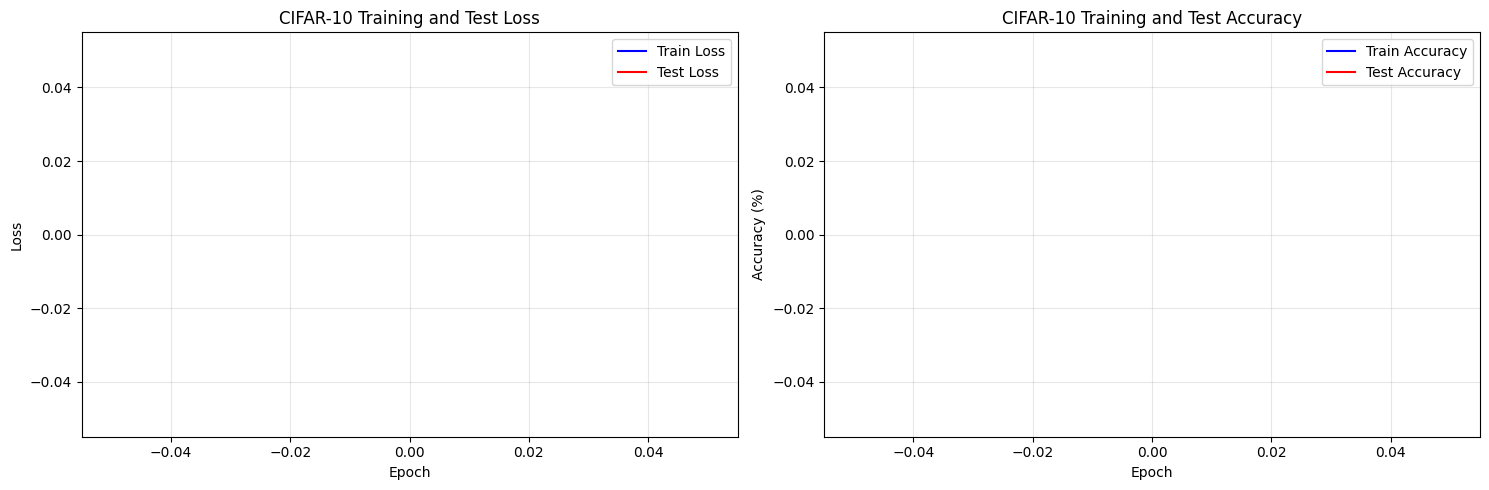

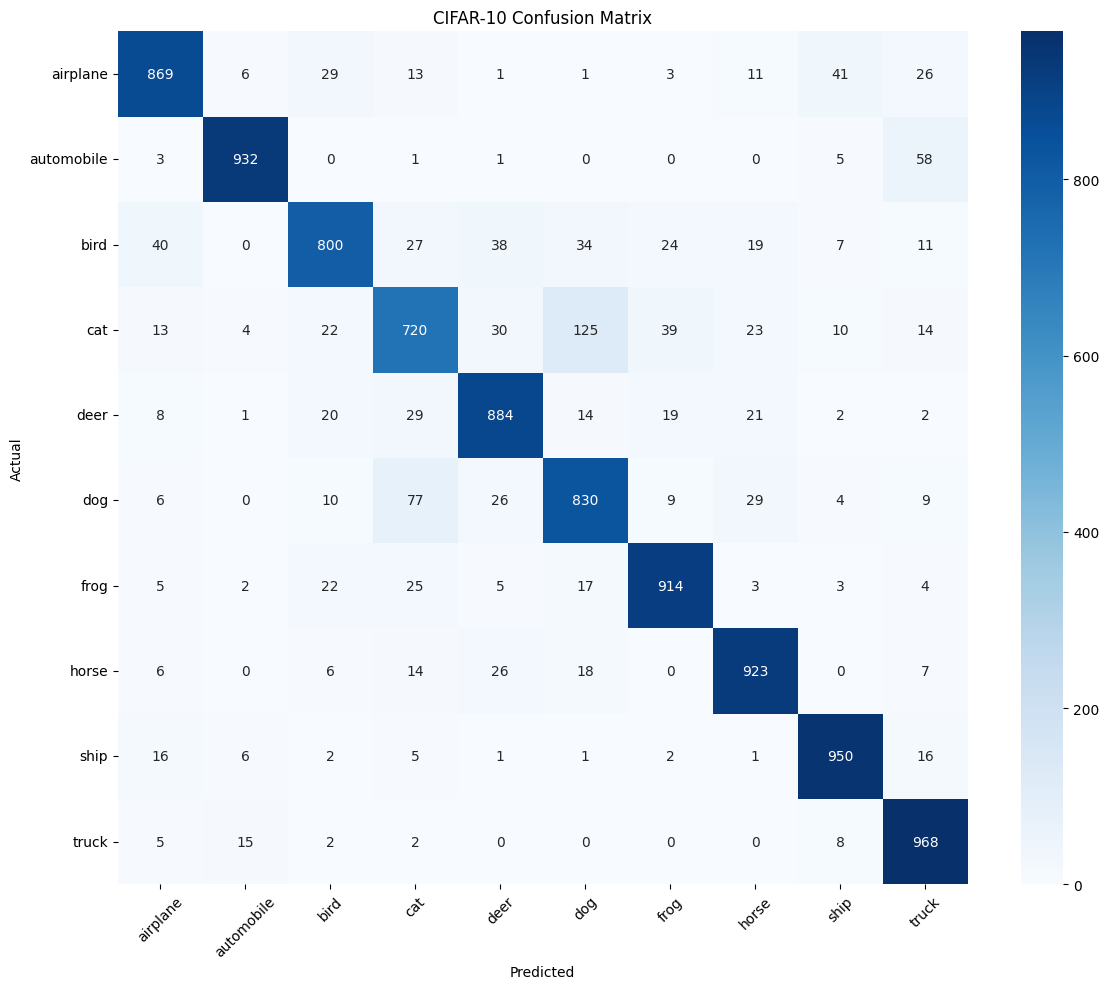


CIFAR-10 Classification Report:
              precision    recall  f1-score   support

    airplane       0.89      0.87      0.88      1000
  automobile       0.96      0.93      0.95      1000
        bird       0.88      0.80      0.84      1000
         cat       0.79      0.72      0.75      1000
        deer       0.87      0.88      0.88      1000
         dog       0.80      0.83      0.81      1000
        frog       0.90      0.91      0.91      1000
       horse       0.90      0.92      0.91      1000
        ship       0.92      0.95      0.94      1000
       truck       0.87      0.97      0.92      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [7]:
# Plot CIFAR-10 training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(train_losses_cifar, label='Train Loss', color='blue')
ax1.plot(test_losses_cifar, label='Test Loss', color='red')
ax1.set_title('CIFAR-10 Training and Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(train_accuracies_cifar, label='Train Accuracy', color='blue')
ax2.plot(test_accuracies_cifar, label='Test Accuracy', color='red')
ax2.set_title('CIFAR-10 Training and Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#Evaluate on test set with detailed metrics
def detailed_evaluation(model, test_loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    return np.array(all_preds), np.array(all_targets)

# Load best CIFAR-10 model and evaluate
model_cifar.load_state_dict(torch.load('best_cifar10_model.pth'))
predictions_cifar, targets_cifar = detailed_evaluation(model_cifar, test_loader_cifar, device)

# CIFAR-10 Confusion matrix
cm_cifar = confusion_matrix(targets_cifar, predictions_cifar)

plt.figure(figsize=(12, 10))
cifar10_classes = cifar_data_info["class_names"]
sns.heatmap(cm_cifar, annot=True, fmt='d', cmap='Blues', 
           xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.title('CIFAR-10 Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# CIFAR-10 Classification report
print("\nCIFAR-10 Classification Report:")
print(classification_report(targets_cifar, predictions_cifar, target_names=cifar10_classes))

In [8]:
mnist_train_loader, mnist_test_loader, cifar_data_info = data.get_mnist_loaders()

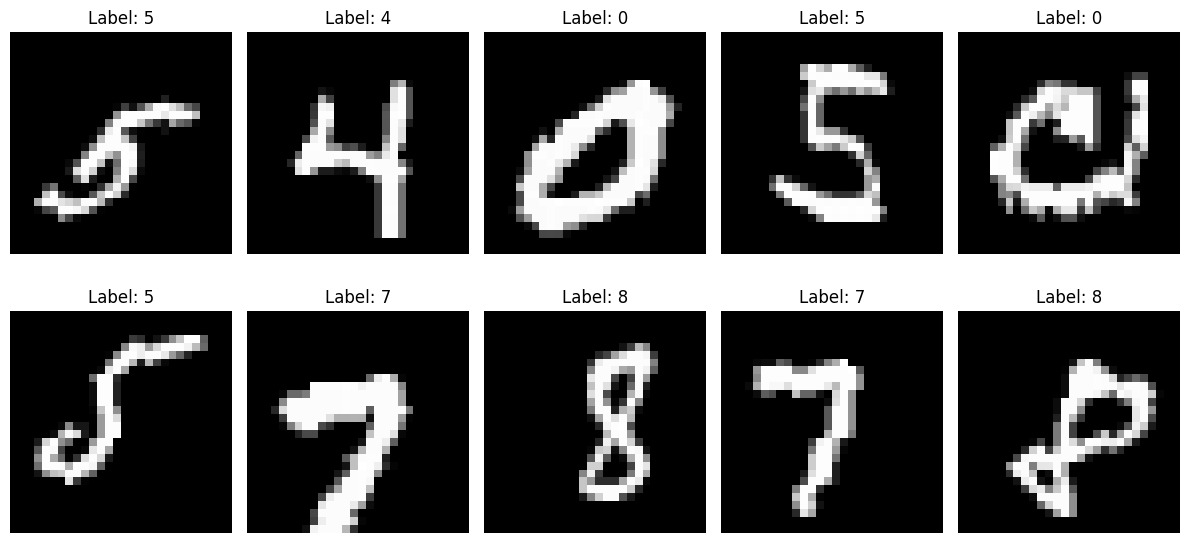

torch.Size([1, 28, 28])

In [9]:
importlib.reload(visualize)
images, labels = visualize.show_mnist_samples(mnist_train_loader)
images[0].shape

In [10]:
# Initialize model
importlib.reload(models)
model = models.MNISTCNN().to(device)
# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 798,058
Trainable parameters: 798,058


In [ ]:
i = iter(mnist_train_loader)

In [20]:
importlib.reload(models)
model = models.ToyCNN().to(device)

In [24]:
data, target = next(i)
data_mps, target_mps = data.to(device, non_blocking=True), target.to(device, non_blocking=True)

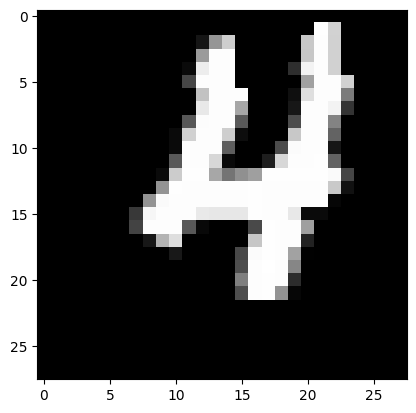

In [36]:
plt.imshow(data[1].squeeze(),cmap='gray')

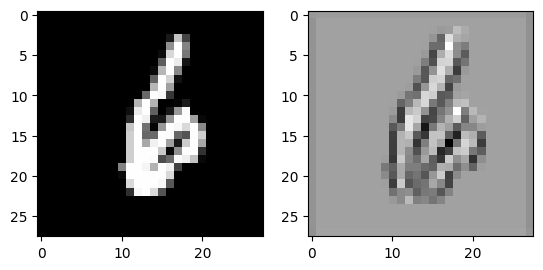

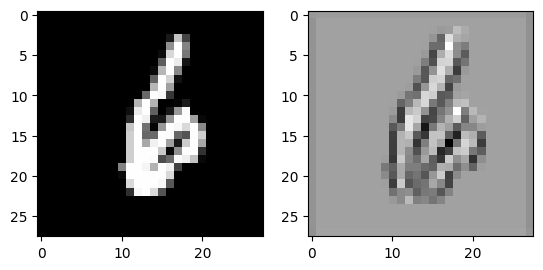

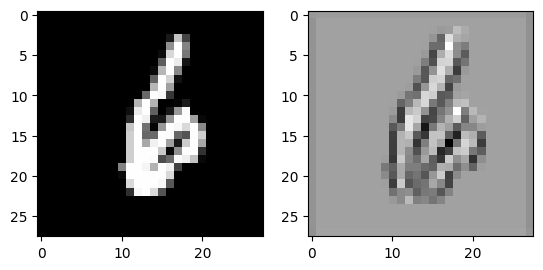

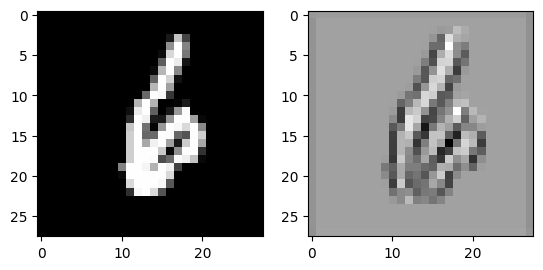

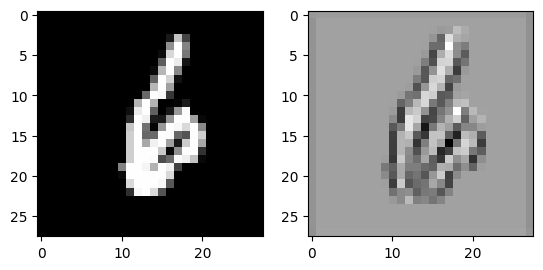

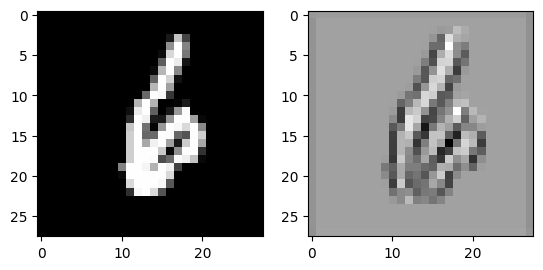

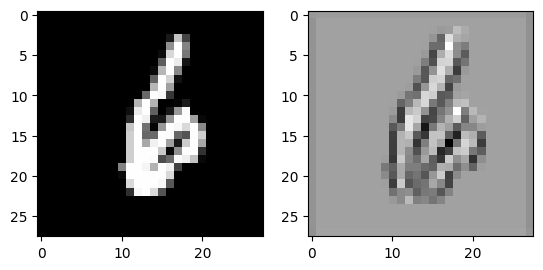

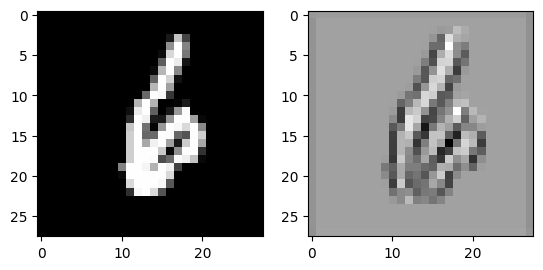

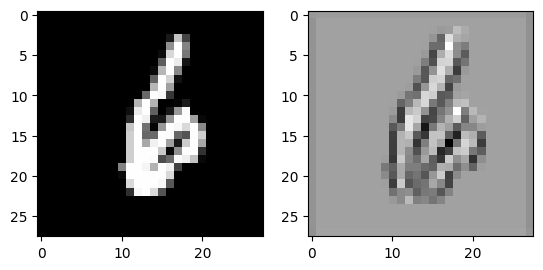

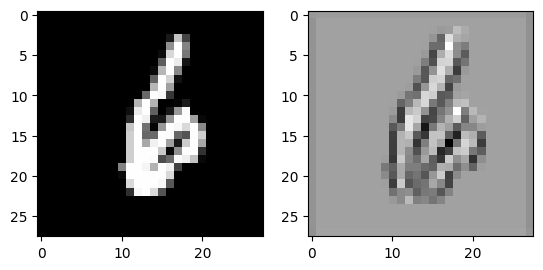

In [33]:
for i in range(10):

    out = model.forward(data_mps[0])
    out_cpu = out.to('cpu')

    fig, axs = plt.subplots(1,2)
    axs[0].imshow(data[0].squeeze(), cmap='gray')
    axs[1].imshow(out_cpu.detach().numpy().squeeze(), cmap='gray')






In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

In [ ]:


# Training loop
num_epochs = 15
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print("Starting training...")
start_time = time.time()

best_accuracy = 0

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 50)
    
    # Train
    train_loss, train_acc = train.train_epoch(model, mnist_train_loader, criterion, optimizer, device)
    
    # Test
    test_loss, test_acc = train.test_epoch(model, mnist_test_loader, criterion, device)
    
    # Update scheduler
    scheduler.step(test_acc)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    # Save best model
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        torch.save(model.state_dict(), 'best_mnist_model.pth')
        print(f"New best model saved! Accuracy: {test_acc:.2f}%")
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

total_time = time.time() - start_time
print(f'\nTraining completed in {total_time:.2f} seconds')
print(f'Best test accuracy: {best_accuracy:.2f}%')



Starting training...

Epoch 1/15
--------------------------------------------------


New best model saved! Accuracy: 98.74%
Train Loss: 0.3521, Train Acc: 89.72%
Test Loss: 0.0358, Test Acc: 98.74%

Epoch 2/15
--------------------------------------------------


New best model saved! Accuracy: 99.24%
Train Loss: 0.1050, Train Acc: 96.92%
Test Loss: 0.0221, Test Acc: 99.24%

Epoch 3/15
--------------------------------------------------


New best model saved! Accuracy: 99.35%
Train Loss: 0.0814, Train Acc: 97.64%
Test Loss: 0.0167, Test Acc: 99.35%

Epoch 4/15
--------------------------------------------------


New best model saved! Accuracy: 99.47%
Train Loss: 0.0711, Train Acc: 97.93%
Test Loss: 0.0167, Test Acc: 99.47%

Epoch 5/15
--------------------------------------------------


Train Loss: 0.0640, Train Acc: 98.15%
Test Loss: 0.0166, Test Acc: 99.44%

Epoch 6/15
--------------------------------------------------


Train Loss: 0.0573, Train Acc: 98.36%
Test Loss: 0.0173, Test Acc: 99.44%

Epoch 7/15
--------------------------------------------------


New best model saved! Accuracy: 99.54%
Train Loss: 0.0542, Train Acc: 98.43%
Test Loss: 0.0138, Test Acc: 99.54%

Epoch 8/15
--------------------------------------------------


Train Loss: 0.0498, Train Acc: 98.57%
Test Loss: 0.0138, Test Acc: 99.54%

Epoch 9/15
--------------------------------------------------


Train Loss: 0.0483, Train Acc: 98.62%
Test Loss: 0.0152, Test Acc: 99.50%

Epoch 10/15
--------------------------------------------------


New best model saved! Accuracy: 99.63%
Train Loss: 0.0491, Train Acc: 98.62%
Test Loss: 0.0126, Test Acc: 99.63%

Epoch 11/15
--------------------------------------------------


Train Loss: 0.0432, Train Acc: 98.76%
Test Loss: 0.0133, Test Acc: 99.58%

Epoch 12/15
--------------------------------------------------


Train Loss: 0.0461, Train Acc: 98.73%
Test Loss: 0.0162, Test Acc: 99.49%

Epoch 13/15
--------------------------------------------------


Train Loss: 0.0399, Train Acc: 98.82%
Test Loss: 0.0124, Test Acc: 99.63%

Epoch 14/15
--------------------------------------------------


Train Loss: 0.0396, Train Acc: 98.86%
Test Loss: 0.0128, Test Acc: 99.54%

Epoch 15/15
--------------------------------------------------


Train Loss: 0.0340, Train Acc: 99.02%
Test Loss: 0.0105, Test Acc: 99.62%

Training completed in 152.63 seconds
Best test accuracy: 99.63%


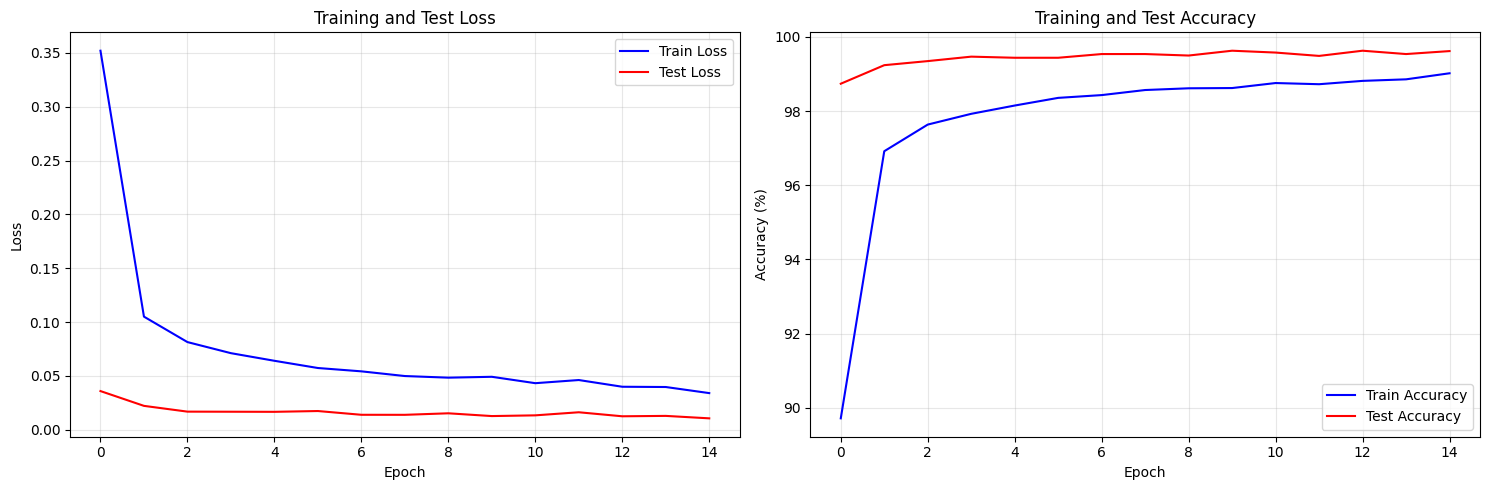

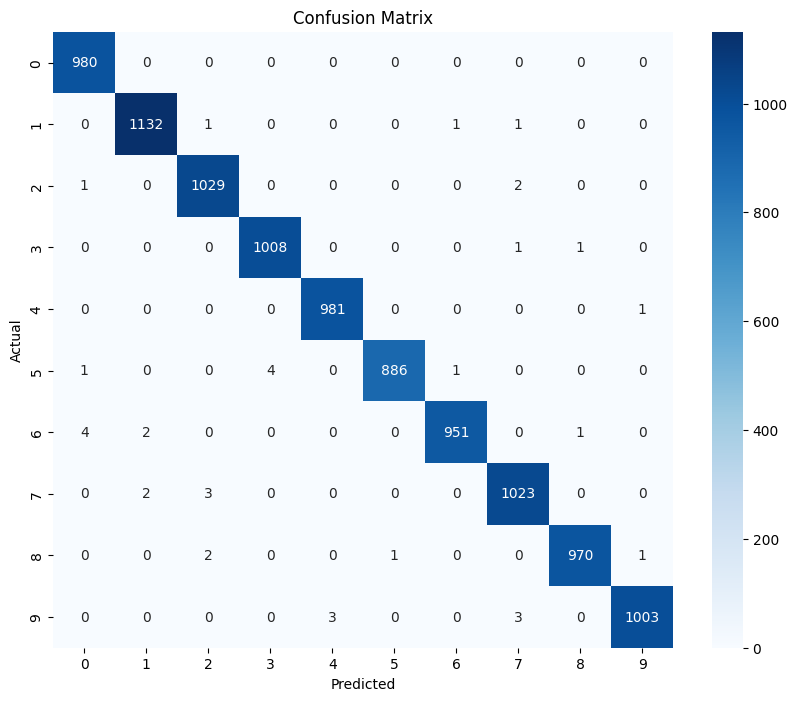


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      1.00      1032
           3       1.00      1.00      1.00      1010
           4       1.00      1.00      1.00       982
           5       1.00      0.99      1.00       892
           6       1.00      0.99      1.00       958
           7       0.99      1.00      0.99      1028
           8       1.00      1.00      1.00       974
           9       1.00      0.99      1.00      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



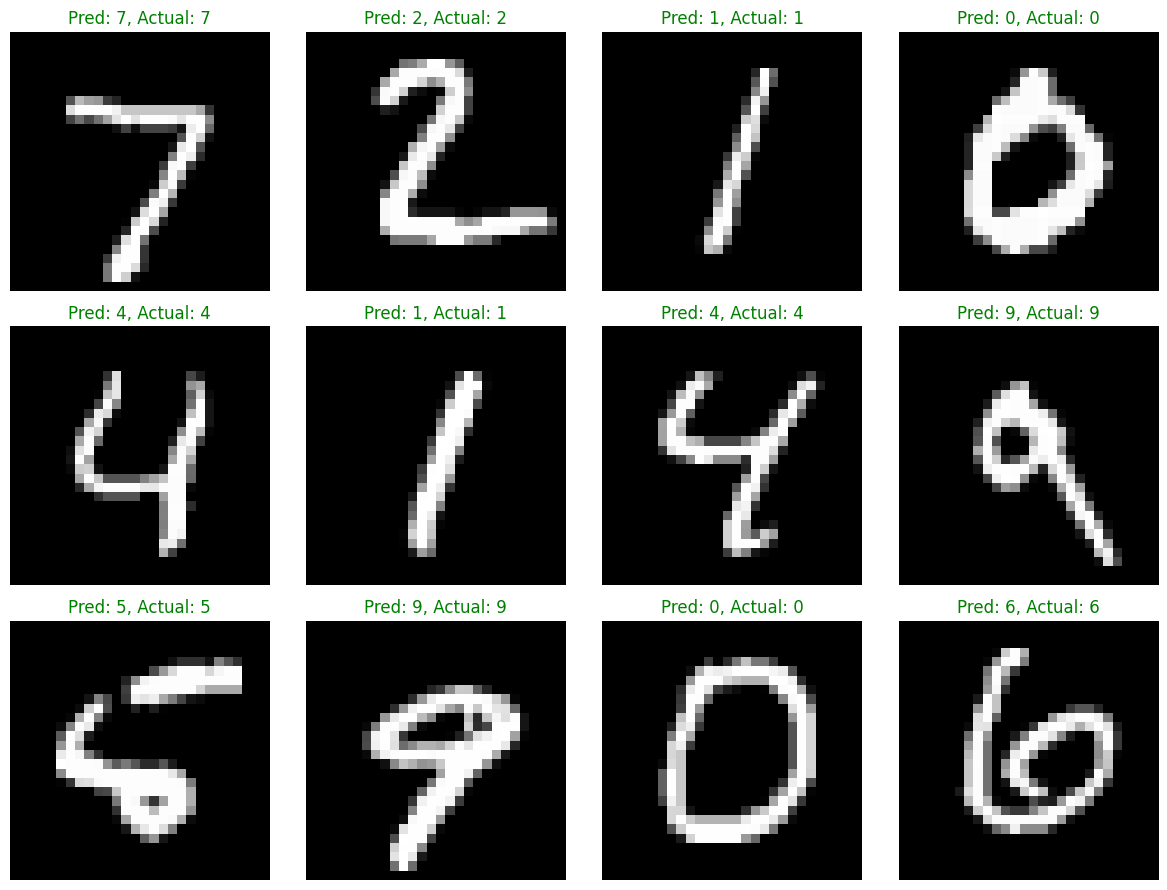


Final Model Performance:
Best Test Accuracy: 99.63%
Total Training Time: 152.63 seconds
Model Size: 798,058 parameters
Device Used: mps

Training history saved to 'training_history.pth'
Best model saved to 'best_mnist_model.pth'


In [ ]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(train_losses, label='Train Loss', color='blue')
ax1.plot(test_losses, label='Test Loss', color='red')
ax1.set_title('Training and Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(train_accuracies, label='Train Accuracy', color='blue')
ax2.plot(test_accuracies, label='Test Accuracy', color='red')
ax2.set_title('Training and Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



# Load best model and evaluate
model.load_state_dict(torch.load('best_mnist_model.pth'))
predictions, targets = detailed_evaluation(model, mnist_test_loader, device)



cm = confusion_matrix(targets, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(targets, predictions, target_names=[str(i) for i in range(10)]))

# Show some predictions
def show_predictions(model, test_loader, device, num_samples=12):
    model.eval()
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    axes = axes.ravel()
    
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    
    with torch.no_grad():
        images_gpu = images.to(device)
        outputs = model(images_gpu)
        predictions = outputs.argmax(dim=1).cpu()
    
    for i in range(num_samples):
        axes[i].imshow(images[i].squeeze(), cmap='gray')
        pred = predictions[i].item()
        actual = labels[i].item()
        color = 'green' if pred == actual else 'red'
        axes[i].set_title(f'Pred: {pred}, Actual: {actual}', color=color)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

show_predictions(model, mnist_test_loader, device)

# Model summary and performance metrics
print(f"\nFinal Model Performance:")
print(f"Best Test Accuracy: {best_accuracy:.2f}%")
print(f"Total Training Time: {total_time:.2f} seconds")
print(f"Model Size: {total_params:,} parameters")
print(f"Device Used: {device}")

# Save training history
training_history = {
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'test_losses': test_losses,
    'test_accuracies': test_accuracies,
    'best_accuracy': best_accuracy,
    'total_time': total_time
}

torch.save(training_history, 'training_history.pth')
print("\nTraining history saved to 'training_history.pth'")
print("Best model saved to 'best_mnist_model.pth'")

In [ ]:
# Comparison between MNIST and CIFAR-10
print("=" * 60)
print("DATASET COMPARISON")
print("=" * 60)

# Note: Run the training sections above to populate these variables
try:
    comparison_data = [
        ["Dataset", "MNIST", "CIFAR-10"],
        ["Image Size", "28x28", "32x32"],
        ["Channels", "1 (Grayscale)", "3 (RGB)"],
        ["Classes", "10", "10"],
        ["Training Samples", "60,000", "50,000"],
        ["Test Samples", "10,000", "10,000"],
        ["Model Parameters", f"{total_params:,}", f"{total_params_cifar:,}"],
        ["Best Accuracy", f"{best_accuracy:.2f}%", f"{best_accuracy_cifar:.2f}%"],
        ["Training Time", f"{total_time:.2f}s", f"{total_time_cifar:.2f}s"],
        ["Complexity", "Low", "High"]
    ]

    for row in comparison_data:
        print(f"{row[0]:<20} {row[1]:<15} {row[2]:<15}")

    print("\n" + "=" * 60)
    print("KEY DIFFERENCES")
    print("=" * 60)
    print("• MNIST: Simple grayscale digits, easier to classify")
    print("• CIFAR-10: Complex RGB images with more variation")
    print("• CIFAR-10 requires deeper architecture and more training")
    print("• CIFAR-10 shows lower accuracy due to increased complexity")
    print("• Both models optimized for Apple Silicon MPS backend")
    
except NameError as e:
    print(f"Variables not defined yet: {e}")
    print("Please run the MNIST and CIFAR-10 training sections first to see the comparison.")
    print("\nDataset Overview:")
    print("• MNIST: 28x28 grayscale digit images, 60k train/10k test")
    print("• CIFAR-10: 32x32 RGB object images, 50k train/10k test")

DATASET COMPARISON
Dataset              MNIST           CIFAR-10       
Image Size           28x28           32x32          
Channels             1 (Grayscale)   3 (RGB)        
Classes              10              10             
Training Samples     60,000          50,000         
Test Samples         10,000          10,000         
Model Parameters     798,058         7,320,394      
Best Accuracy        99.63%          0.00%          
Training Time        152.63s         0.00s          
Complexity           Low             High           

KEY DIFFERENCES
• MNIST: Simple grayscale digits, easier to classify
• CIFAR-10: Complex RGB images with more variation
• CIFAR-10 requires deeper architecture and more training
• CIFAR-10 shows lower accuracy due to increased complexity
• Both models optimized for Apple Silicon MPS backend
